# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

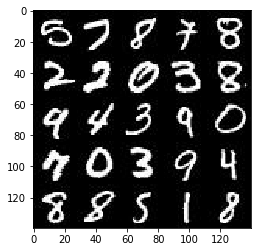

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

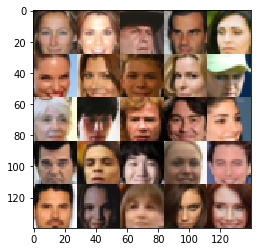

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input_real, input_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        # x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 16x16x256 now
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        #logits = tf.slice(logits, [0, 2, 2, 0], [-1, 28, 28, -1])
        out = tf.tanh(logits)
        
        return out
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    n_samples, width, height, channels = data_shape
    input_real, input_z, learn_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    show_every = 50
    print_every = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                # TODO: Train Model
                steps += 1
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})

                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, channels, data_image_mode)

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))               
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 8.5140... Generator Loss: 0.0003
Epoch 0/2... Discriminator Loss: 3.6108... Generator Loss: 0.0668
Epoch 0/2... Discriminator Loss: 2.4611... Generator Loss: 5.6333
Epoch 0/2... Discriminator Loss: 0.8260... Generator Loss: 3.0077


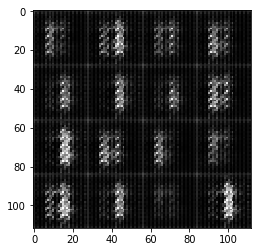

Epoch 0/2... Discriminator Loss: 1.1195... Generator Loss: 1.6994
Epoch 0/2... Discriminator Loss: 0.5629... Generator Loss: 4.0761
Epoch 0/2... Discriminator Loss: 2.0052... Generator Loss: 5.6132
Epoch 0/2... Discriminator Loss: 0.6540... Generator Loss: 3.6345
Epoch 0/2... Discriminator Loss: 2.0375... Generator Loss: 3.1174


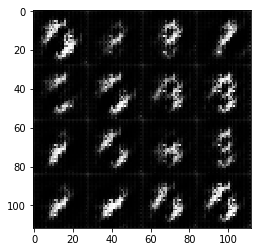

Epoch 0/2... Discriminator Loss: 1.2745... Generator Loss: 2.5982
Epoch 0/2... Discriminator Loss: 1.1530... Generator Loss: 3.5352
Epoch 0/2... Discriminator Loss: 1.1068... Generator Loss: 1.5601
Epoch 0/2... Discriminator Loss: 1.4640... Generator Loss: 3.1787
Epoch 0/2... Discriminator Loss: 1.7672... Generator Loss: 2.7006


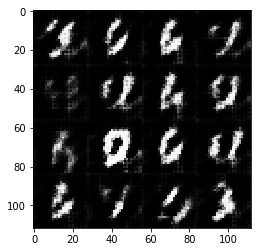

Epoch 0/2... Discriminator Loss: 1.2874... Generator Loss: 1.6922
Epoch 0/2... Discriminator Loss: 1.7234... Generator Loss: 1.3984
Epoch 0/2... Discriminator Loss: 1.3289... Generator Loss: 0.9357
Epoch 0/2... Discriminator Loss: 1.0086... Generator Loss: 1.0691
Epoch 0/2... Discriminator Loss: 1.2930... Generator Loss: 1.0155


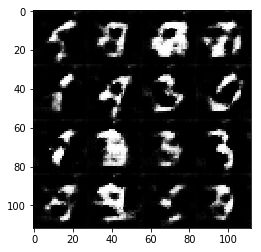

Epoch 0/2... Discriminator Loss: 1.7270... Generator Loss: 2.4769
Epoch 0/2... Discriminator Loss: 1.4020... Generator Loss: 2.1710
Epoch 0/2... Discriminator Loss: 1.2873... Generator Loss: 1.5074
Epoch 0/2... Discriminator Loss: 1.3220... Generator Loss: 1.5206
Epoch 0/2... Discriminator Loss: 1.4258... Generator Loss: 2.1655


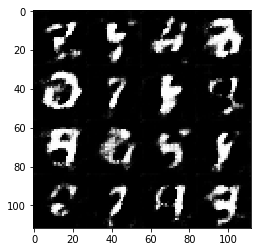

Epoch 0/2... Discriminator Loss: 1.3759... Generator Loss: 1.7663
Epoch 0/2... Discriminator Loss: 1.6318... Generator Loss: 1.9183
Epoch 0/2... Discriminator Loss: 1.3130... Generator Loss: 1.1327
Epoch 0/2... Discriminator Loss: 1.5549... Generator Loss: 0.9682
Epoch 0/2... Discriminator Loss: 1.6721... Generator Loss: 0.3074


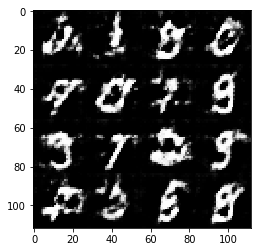

Epoch 0/2... Discriminator Loss: 1.3366... Generator Loss: 0.4284
Epoch 0/2... Discriminator Loss: 1.5074... Generator Loss: 0.3967
Epoch 0/2... Discriminator Loss: 1.5547... Generator Loss: 0.3455
Epoch 0/2... Discriminator Loss: 1.2647... Generator Loss: 0.5051
Epoch 0/2... Discriminator Loss: 1.4682... Generator Loss: 0.4720


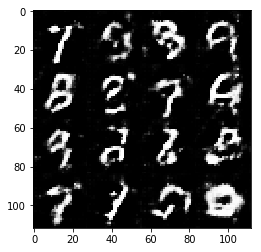

Epoch 0/2... Discriminator Loss: 1.4950... Generator Loss: 0.3524
Epoch 0/2... Discriminator Loss: 1.4338... Generator Loss: 0.4322
Epoch 0/2... Discriminator Loss: 1.5909... Generator Loss: 0.4239
Epoch 0/2... Discriminator Loss: 1.6115... Generator Loss: 0.2961
Epoch 0/2... Discriminator Loss: 1.4366... Generator Loss: 1.7627


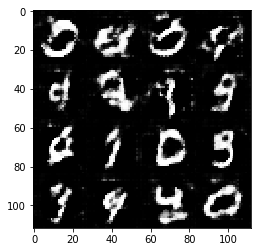

Epoch 0/2... Discriminator Loss: 1.3722... Generator Loss: 1.7704
Epoch 0/2... Discriminator Loss: 1.3806... Generator Loss: 1.6024
Epoch 0/2... Discriminator Loss: 1.2323... Generator Loss: 1.4415
Epoch 0/2... Discriminator Loss: 1.2894... Generator Loss: 1.6225
Epoch 0/2... Discriminator Loss: 0.8799... Generator Loss: 1.0099


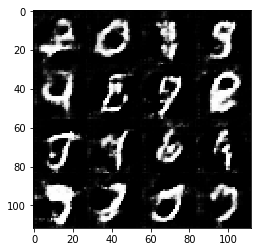

Epoch 0/2... Discriminator Loss: 1.2763... Generator Loss: 1.3832
Epoch 0/2... Discriminator Loss: 1.2470... Generator Loss: 1.0047
Epoch 0/2... Discriminator Loss: 1.2416... Generator Loss: 1.1033
Epoch 0/2... Discriminator Loss: 1.4812... Generator Loss: 1.1818
Epoch 0/2... Discriminator Loss: 1.2616... Generator Loss: 1.6416


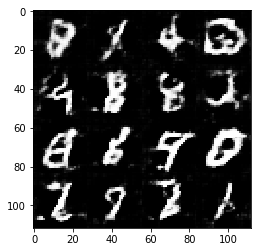

Epoch 0/2... Discriminator Loss: 1.0612... Generator Loss: 1.3681
Epoch 0/2... Discriminator Loss: 1.3914... Generator Loss: 1.1762
Epoch 0/2... Discriminator Loss: 1.1906... Generator Loss: 1.1167
Epoch 0/2... Discriminator Loss: 1.3248... Generator Loss: 1.0954
Epoch 0/2... Discriminator Loss: 1.1873... Generator Loss: 1.3103


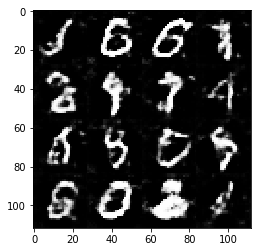

Epoch 0/2... Discriminator Loss: 1.4150... Generator Loss: 1.3057
Epoch 0/2... Discriminator Loss: 1.7785... Generator Loss: 2.1457
Epoch 0/2... Discriminator Loss: 1.4263... Generator Loss: 1.1965
Epoch 0/2... Discriminator Loss: 1.2120... Generator Loss: 1.2874
Epoch 0/2... Discriminator Loss: 1.1136... Generator Loss: 1.1684


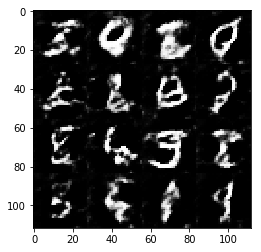

Epoch 0/2... Discriminator Loss: 1.2929... Generator Loss: 0.7753
Epoch 0/2... Discriminator Loss: 1.5971... Generator Loss: 0.3194
Epoch 0/2... Discriminator Loss: 1.3856... Generator Loss: 0.4429
Epoch 0/2... Discriminator Loss: 1.5272... Generator Loss: 0.3839
Epoch 0/2... Discriminator Loss: 1.3213... Generator Loss: 0.4256


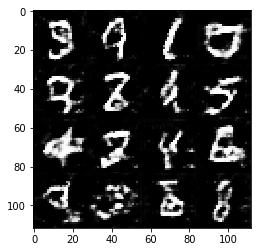

Epoch 0/2... Discriminator Loss: 1.4313... Generator Loss: 0.3856
Epoch 0/2... Discriminator Loss: 1.4622... Generator Loss: 0.3965
Epoch 0/2... Discriminator Loss: 1.6465... Generator Loss: 0.3191
Epoch 0/2... Discriminator Loss: 1.4733... Generator Loss: 0.3725
Epoch 0/2... Discriminator Loss: 1.6427... Generator Loss: 0.3054


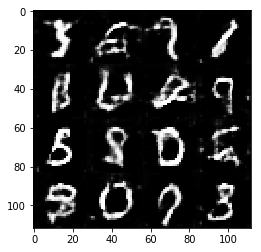

Epoch 0/2... Discriminator Loss: 1.2546... Generator Loss: 0.5687
Epoch 0/2... Discriminator Loss: 1.7889... Generator Loss: 0.2451
Epoch 0/2... Discriminator Loss: 1.4912... Generator Loss: 0.3826
Epoch 0/2... Discriminator Loss: 1.2433... Generator Loss: 0.5989
Epoch 0/2... Discriminator Loss: 1.6034... Generator Loss: 0.3276


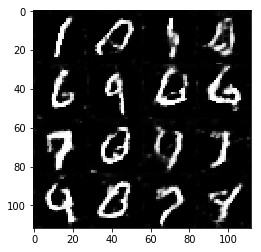

Epoch 0/2... Discriminator Loss: 1.2604... Generator Loss: 0.5116
Epoch 0/2... Discriminator Loss: 1.3981... Generator Loss: 0.4928
Epoch 0/2... Discriminator Loss: 1.3570... Generator Loss: 0.4385
Epoch 0/2... Discriminator Loss: 1.3702... Generator Loss: 0.4244
Epoch 0/2... Discriminator Loss: 1.3792... Generator Loss: 0.4676


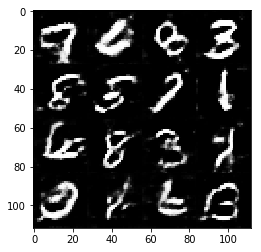

Epoch 0/2... Discriminator Loss: 1.4955... Generator Loss: 0.3408
Epoch 0/2... Discriminator Loss: 1.5549... Generator Loss: 0.3743
Epoch 0/2... Discriminator Loss: 1.4994... Generator Loss: 0.3801
Epoch 0/2... Discriminator Loss: 1.4831... Generator Loss: 0.4253
Epoch 0/2... Discriminator Loss: 1.2933... Generator Loss: 0.6187


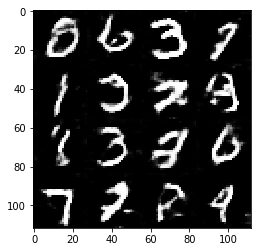

Epoch 0/2... Discriminator Loss: 1.3476... Generator Loss: 0.4816
Epoch 0/2... Discriminator Loss: 1.3419... Generator Loss: 0.4596
Epoch 0/2... Discriminator Loss: 1.2186... Generator Loss: 0.6869
Epoch 0/2... Discriminator Loss: 1.4868... Generator Loss: 0.4188
Epoch 0/2... Discriminator Loss: 1.3549... Generator Loss: 0.4081


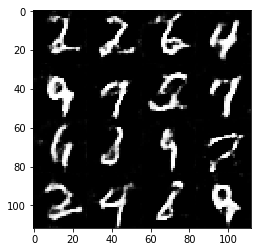

Epoch 0/2... Discriminator Loss: 1.2668... Generator Loss: 0.4785
Epoch 0/2... Discriminator Loss: 1.3360... Generator Loss: 1.2991
Epoch 0/2... Discriminator Loss: 1.2267... Generator Loss: 1.1430
Epoch 0/2... Discriminator Loss: 1.5437... Generator Loss: 1.7955
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 0.9010


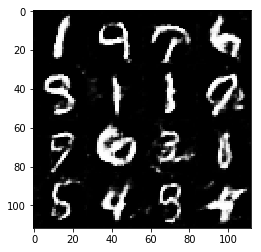

Epoch 1/2... Discriminator Loss: 1.5408... Generator Loss: 0.3276
Epoch 1/2... Discriminator Loss: 1.4801... Generator Loss: 0.3421
Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 0.4227
Epoch 1/2... Discriminator Loss: 1.3967... Generator Loss: 0.4876
Epoch 1/2... Discriminator Loss: 1.0960... Generator Loss: 0.6073


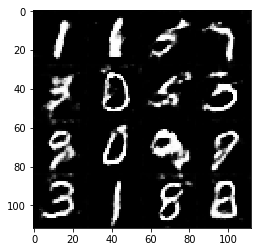

Epoch 1/2... Discriminator Loss: 1.7487... Generator Loss: 0.2895
Epoch 1/2... Discriminator Loss: 1.8997... Generator Loss: 0.2385
Epoch 1/2... Discriminator Loss: 1.0213... Generator Loss: 1.0772
Epoch 1/2... Discriminator Loss: 1.2334... Generator Loss: 0.8377
Epoch 1/2... Discriminator Loss: 1.2667... Generator Loss: 1.4338


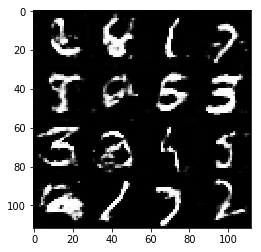

Epoch 1/2... Discriminator Loss: 2.2859... Generator Loss: 2.6367
Epoch 1/2... Discriminator Loss: 1.2521... Generator Loss: 0.7799
Epoch 1/2... Discriminator Loss: 1.1867... Generator Loss: 1.5075
Epoch 1/2... Discriminator Loss: 1.1154... Generator Loss: 1.4028
Epoch 1/2... Discriminator Loss: 1.2366... Generator Loss: 1.5350


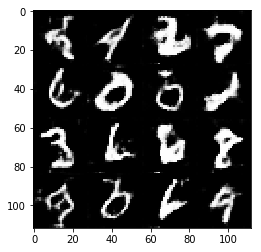

Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 1.5038
Epoch 1/2... Discriminator Loss: 1.2613... Generator Loss: 0.6311
Epoch 1/2... Discriminator Loss: 1.0120... Generator Loss: 0.8886
Epoch 1/2... Discriminator Loss: 1.1753... Generator Loss: 1.1975
Epoch 1/2... Discriminator Loss: 1.0208... Generator Loss: 1.1760


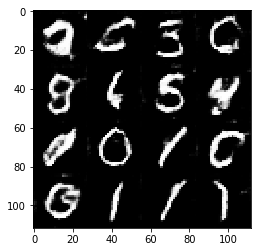

Epoch 1/2... Discriminator Loss: 1.2030... Generator Loss: 1.4197
Epoch 1/2... Discriminator Loss: 1.4204... Generator Loss: 1.5995
Epoch 1/2... Discriminator Loss: 1.1857... Generator Loss: 0.7495
Epoch 1/2... Discriminator Loss: 1.1838... Generator Loss: 1.8811
Epoch 1/2... Discriminator Loss: 0.8887... Generator Loss: 1.1582


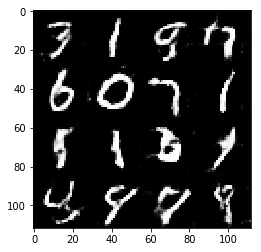

Epoch 1/2... Discriminator Loss: 1.3022... Generator Loss: 1.1383
Epoch 1/2... Discriminator Loss: 1.0182... Generator Loss: 0.8072
Epoch 1/2... Discriminator Loss: 1.0032... Generator Loss: 0.8647
Epoch 1/2... Discriminator Loss: 1.7389... Generator Loss: 0.2961
Epoch 1/2... Discriminator Loss: 0.8422... Generator Loss: 2.1284


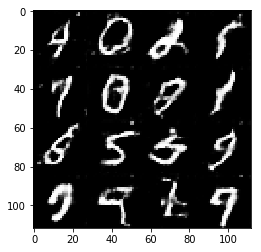

Epoch 1/2... Discriminator Loss: 1.3447... Generator Loss: 0.4614
Epoch 1/2... Discriminator Loss: 1.4934... Generator Loss: 0.3605
Epoch 1/2... Discriminator Loss: 1.5602... Generator Loss: 0.3510
Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 0.4246
Epoch 1/2... Discriminator Loss: 1.2483... Generator Loss: 0.4864


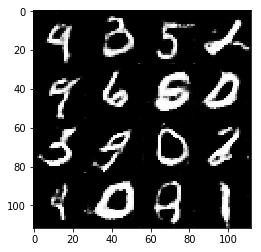

Epoch 1/2... Discriminator Loss: 2.0382... Generator Loss: 0.1852
Epoch 1/2... Discriminator Loss: 1.4371... Generator Loss: 0.3991
Epoch 1/2... Discriminator Loss: 1.6131... Generator Loss: 0.3284
Epoch 1/2... Discriminator Loss: 0.8679... Generator Loss: 1.0999
Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 1.1679


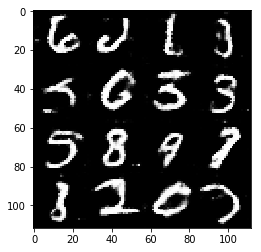

Epoch 1/2... Discriminator Loss: 1.5586... Generator Loss: 2.8438
Epoch 1/2... Discriminator Loss: 1.4894... Generator Loss: 0.3550
Epoch 1/2... Discriminator Loss: 1.4370... Generator Loss: 0.4299
Epoch 1/2... Discriminator Loss: 2.2213... Generator Loss: 2.9856
Epoch 1/2... Discriminator Loss: 1.1252... Generator Loss: 0.5912


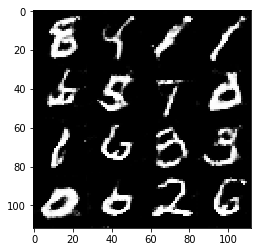

Epoch 1/2... Discriminator Loss: 1.4690... Generator Loss: 0.3774
Epoch 1/2... Discriminator Loss: 1.1495... Generator Loss: 0.7052
Epoch 1/2... Discriminator Loss: 1.1139... Generator Loss: 0.9397
Epoch 1/2... Discriminator Loss: 0.9943... Generator Loss: 1.3911
Epoch 1/2... Discriminator Loss: 1.1960... Generator Loss: 1.6696


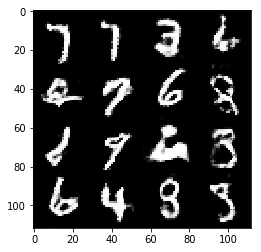

Epoch 1/2... Discriminator Loss: 0.6920... Generator Loss: 1.2504
Epoch 1/2... Discriminator Loss: 1.2002... Generator Loss: 1.8912
Epoch 1/2... Discriminator Loss: 1.4406... Generator Loss: 2.5291
Epoch 1/2... Discriminator Loss: 0.7440... Generator Loss: 1.0393
Epoch 1/2... Discriminator Loss: 1.5926... Generator Loss: 2.2092


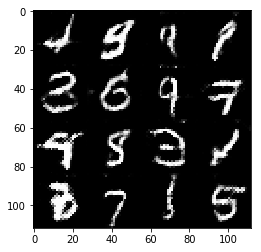

Epoch 1/2... Discriminator Loss: 0.5891... Generator Loss: 1.1394
Epoch 1/2... Discriminator Loss: 0.4935... Generator Loss: 1.2681
Epoch 1/2... Discriminator Loss: 1.1554... Generator Loss: 0.5547
Epoch 1/2... Discriminator Loss: 0.5235... Generator Loss: 2.1920
Epoch 1/2... Discriminator Loss: 0.8670... Generator Loss: 1.6373


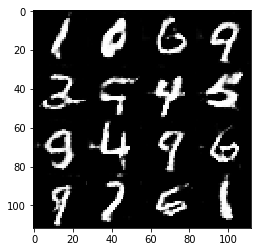

Epoch 1/2... Discriminator Loss: 0.9381... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 0.8210... Generator Loss: 1.3953
Epoch 1/2... Discriminator Loss: 1.2294... Generator Loss: 2.6750
Epoch 1/2... Discriminator Loss: 1.3830... Generator Loss: 0.5326
Epoch 1/2... Discriminator Loss: 0.4030... Generator Loss: 1.7258


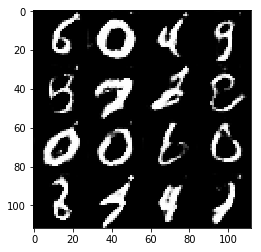

Epoch 1/2... Discriminator Loss: 0.7528... Generator Loss: 0.9060
Epoch 1/2... Discriminator Loss: 1.1579... Generator Loss: 0.5659
Epoch 1/2... Discriminator Loss: 1.2196... Generator Loss: 2.2079
Epoch 1/2... Discriminator Loss: 1.6576... Generator Loss: 0.3337
Epoch 1/2... Discriminator Loss: 1.3651... Generator Loss: 0.4412


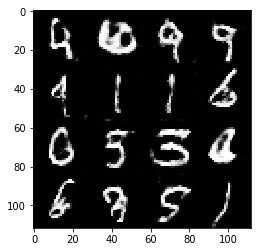

Epoch 1/2... Discriminator Loss: 1.0247... Generator Loss: 2.5581
Epoch 1/2... Discriminator Loss: 0.9043... Generator Loss: 1.5294
Epoch 1/2... Discriminator Loss: 0.9935... Generator Loss: 1.9149
Epoch 1/2... Discriminator Loss: 0.6252... Generator Loss: 1.3567
Epoch 1/2... Discriminator Loss: 0.5638... Generator Loss: 3.5300


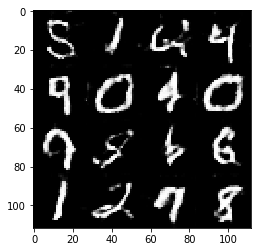

Epoch 1/2... Discriminator Loss: 0.7792... Generator Loss: 1.3340
Epoch 1/2... Discriminator Loss: 0.5036... Generator Loss: 2.7151
Epoch 1/2... Discriminator Loss: 5.6961... Generator Loss: 5.3755
Epoch 1/2... Discriminator Loss: 0.9957... Generator Loss: 0.9237
Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 0.6259


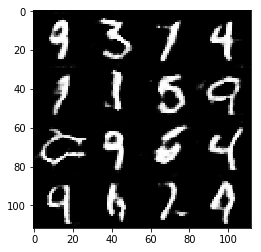

Epoch 1/2... Discriminator Loss: 1.6855... Generator Loss: 0.3598
Epoch 1/2... Discriminator Loss: 1.0201... Generator Loss: 0.6994
Epoch 1/2... Discriminator Loss: 1.6370... Generator Loss: 0.3059
Epoch 1/2... Discriminator Loss: 0.6810... Generator Loss: 1.5521
Epoch 1/2... Discriminator Loss: 1.1017... Generator Loss: 0.5600


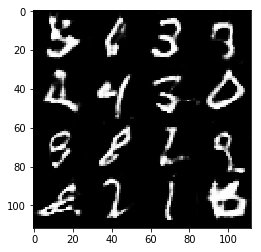

Epoch 1/2... Discriminator Loss: 1.8453... Generator Loss: 0.2608
Epoch 1/2... Discriminator Loss: 0.5876... Generator Loss: 1.0818
Epoch 1/2... Discriminator Loss: 2.3696... Generator Loss: 0.1641
Epoch 1/2... Discriminator Loss: 1.2261... Generator Loss: 0.5453
Epoch 1/2... Discriminator Loss: 0.6368... Generator Loss: 1.0821


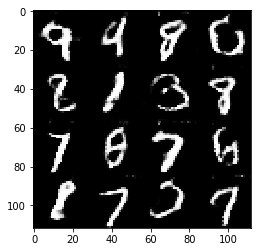

Epoch 1/2... Discriminator Loss: 2.5824... Generator Loss: 0.1240
Epoch 1/2... Discriminator Loss: 1.3229... Generator Loss: 0.4859
Epoch 1/2... Discriminator Loss: 1.0460... Generator Loss: 0.6011


In [16]:

batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.6218... Generator Loss: 6.7542
Epoch 0/1... Discriminator Loss: 0.2210... Generator Loss: 12.0185
Epoch 0/1... Discriminator Loss: 0.0837... Generator Loss: 13.6359
Epoch 0/1... Discriminator Loss: 0.1474... Generator Loss: 2.6577


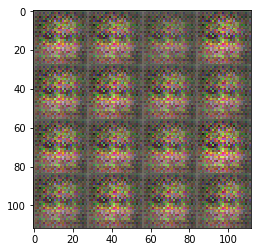

Epoch 0/1... Discriminator Loss: 0.0799... Generator Loss: 9.0542
Epoch 0/1... Discriminator Loss: 0.9694... Generator Loss: 0.5213
Epoch 0/1... Discriminator Loss: 1.7996... Generator Loss: 0.2328
Epoch 0/1... Discriminator Loss: 0.0940... Generator Loss: 4.6129
Epoch 0/1... Discriminator Loss: 0.5094... Generator Loss: 10.7036


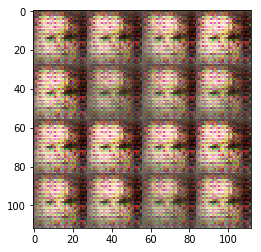

Epoch 0/1... Discriminator Loss: 0.6884... Generator Loss: 1.5429
Epoch 0/1... Discriminator Loss: 0.3922... Generator Loss: 6.2053
Epoch 0/1... Discriminator Loss: 0.6844... Generator Loss: 1.8742
Epoch 0/1... Discriminator Loss: 0.2767... Generator Loss: 5.0851
Epoch 0/1... Discriminator Loss: 0.2680... Generator Loss: 2.0566


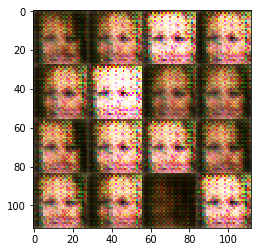

Epoch 0/1... Discriminator Loss: 0.2183... Generator Loss: 3.0680
Epoch 0/1... Discriminator Loss: 1.3807... Generator Loss: 8.8281
Epoch 0/1... Discriminator Loss: 0.6517... Generator Loss: 1.0631
Epoch 0/1... Discriminator Loss: 0.6843... Generator Loss: 0.9577
Epoch 0/1... Discriminator Loss: 0.6783... Generator Loss: 3.8748


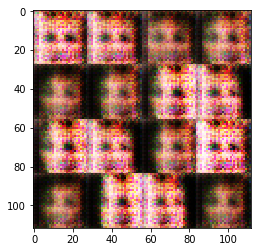

Epoch 0/1... Discriminator Loss: 0.3414... Generator Loss: 2.8515
Epoch 0/1... Discriminator Loss: 0.3575... Generator Loss: 2.2995
Epoch 0/1... Discriminator Loss: 1.2567... Generator Loss: 0.5501
Epoch 0/1... Discriminator Loss: 0.8016... Generator Loss: 5.2044
Epoch 0/1... Discriminator Loss: 0.8977... Generator Loss: 2.9335


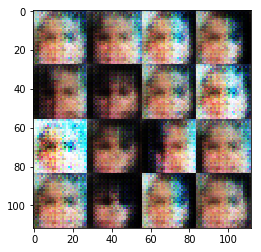

Epoch 0/1... Discriminator Loss: 0.5397... Generator Loss: 1.6186
Epoch 0/1... Discriminator Loss: 0.9090... Generator Loss: 1.8203
Epoch 0/1... Discriminator Loss: 0.8011... Generator Loss: 2.2234
Epoch 0/1... Discriminator Loss: 0.7014... Generator Loss: 1.4191
Epoch 0/1... Discriminator Loss: 1.0575... Generator Loss: 1.1094


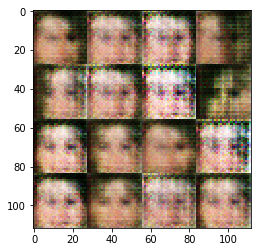

Epoch 0/1... Discriminator Loss: 0.9031... Generator Loss: 1.3718
Epoch 0/1... Discriminator Loss: 1.5967... Generator Loss: 0.9122
Epoch 0/1... Discriminator Loss: 0.9074... Generator Loss: 1.2662
Epoch 0/1... Discriminator Loss: 1.1536... Generator Loss: 0.8921
Epoch 0/1... Discriminator Loss: 2.0748... Generator Loss: 0.2825


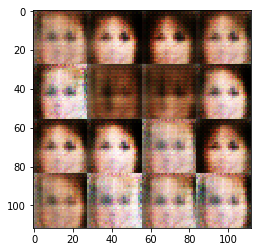

Epoch 0/1... Discriminator Loss: 1.0040... Generator Loss: 1.0685
Epoch 0/1... Discriminator Loss: 1.0116... Generator Loss: 0.9163
Epoch 0/1... Discriminator Loss: 0.7967... Generator Loss: 1.0896
Epoch 0/1... Discriminator Loss: 0.9013... Generator Loss: 1.3306
Epoch 0/1... Discriminator Loss: 0.9746... Generator Loss: 1.2997


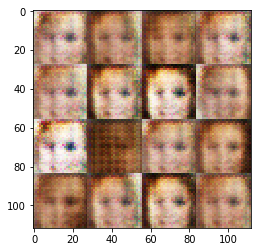

Epoch 0/1... Discriminator Loss: 0.9752... Generator Loss: 1.5311
Epoch 0/1... Discriminator Loss: 0.7305... Generator Loss: 1.5061
Epoch 0/1... Discriminator Loss: 0.5503... Generator Loss: 1.3170
Epoch 0/1... Discriminator Loss: 1.0364... Generator Loss: 0.7458
Epoch 0/1... Discriminator Loss: 1.0248... Generator Loss: 0.8532


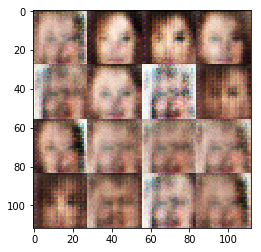

Epoch 0/1... Discriminator Loss: 1.0175... Generator Loss: 1.0297
Epoch 0/1... Discriminator Loss: 1.2304... Generator Loss: 1.2793
Epoch 0/1... Discriminator Loss: 1.3685... Generator Loss: 1.1291
Epoch 0/1... Discriminator Loss: 0.9097... Generator Loss: 1.2895
Epoch 0/1... Discriminator Loss: 0.9766... Generator Loss: 1.7817


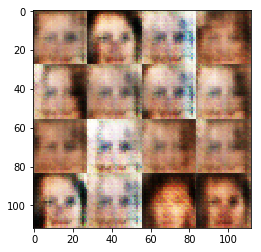

Epoch 0/1... Discriminator Loss: 1.1587... Generator Loss: 0.8739
Epoch 0/1... Discriminator Loss: 0.8369... Generator Loss: 1.7000
Epoch 0/1... Discriminator Loss: 1.3175... Generator Loss: 2.2688
Epoch 0/1... Discriminator Loss: 0.9237... Generator Loss: 0.7978
Epoch 0/1... Discriminator Loss: 0.7502... Generator Loss: 1.2931


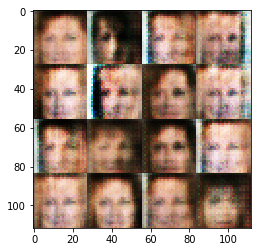

Epoch 0/1... Discriminator Loss: 1.1444... Generator Loss: 1.0582
Epoch 0/1... Discriminator Loss: 0.9437... Generator Loss: 1.4002
Epoch 0/1... Discriminator Loss: 0.8985... Generator Loss: 0.6887
Epoch 0/1... Discriminator Loss: 1.1120... Generator Loss: 0.6667
Epoch 0/1... Discriminator Loss: 0.3703... Generator Loss: 1.7196


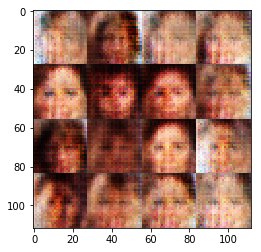

Epoch 0/1... Discriminator Loss: 4.7015... Generator Loss: 6.9979
Epoch 0/1... Discriminator Loss: 0.8447... Generator Loss: 1.0757
Epoch 0/1... Discriminator Loss: 0.8757... Generator Loss: 1.5791
Epoch 0/1... Discriminator Loss: 0.9750... Generator Loss: 0.9356
Epoch 0/1... Discriminator Loss: 0.9773... Generator Loss: 0.7636


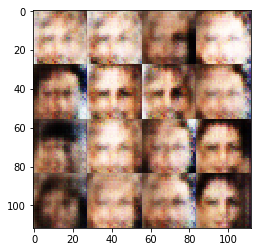

Epoch 0/1... Discriminator Loss: 1.1661... Generator Loss: 2.4567
Epoch 0/1... Discriminator Loss: 0.7715... Generator Loss: 1.8850
Epoch 0/1... Discriminator Loss: 1.4794... Generator Loss: 0.3984
Epoch 0/1... Discriminator Loss: 1.4443... Generator Loss: 0.5665
Epoch 0/1... Discriminator Loss: 0.9071... Generator Loss: 2.1894


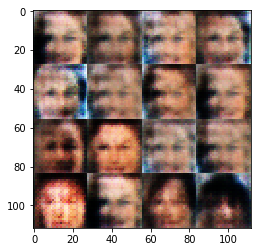

Epoch 0/1... Discriminator Loss: 1.1729... Generator Loss: 1.5581
Epoch 0/1... Discriminator Loss: 0.8425... Generator Loss: 1.9790
Epoch 0/1... Discriminator Loss: 1.2685... Generator Loss: 1.8635
Epoch 0/1... Discriminator Loss: 1.3507... Generator Loss: 2.4140
Epoch 0/1... Discriminator Loss: 0.6444... Generator Loss: 1.5539


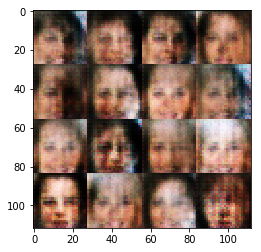

Epoch 0/1... Discriminator Loss: 1.2362... Generator Loss: 0.8157
Epoch 0/1... Discriminator Loss: 0.9081... Generator Loss: 0.9835
Epoch 0/1... Discriminator Loss: 1.1440... Generator Loss: 0.7494
Epoch 0/1... Discriminator Loss: 0.8863... Generator Loss: 1.1121
Epoch 0/1... Discriminator Loss: 0.7551... Generator Loss: 1.5537


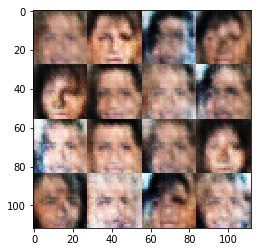

Epoch 0/1... Discriminator Loss: 0.8504... Generator Loss: 1.0750
Epoch 0/1... Discriminator Loss: 1.2803... Generator Loss: 0.5488
Epoch 0/1... Discriminator Loss: 0.7217... Generator Loss: 1.2239
Epoch 0/1... Discriminator Loss: 0.9225... Generator Loss: 1.5334
Epoch 0/1... Discriminator Loss: 1.0059... Generator Loss: 1.1359


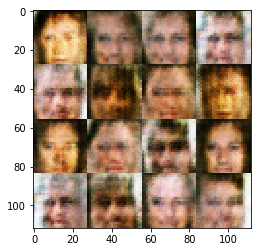

Epoch 0/1... Discriminator Loss: 0.9815... Generator Loss: 0.8485
Epoch 0/1... Discriminator Loss: 0.8469... Generator Loss: 0.9791
Epoch 0/1... Discriminator Loss: 0.8377... Generator Loss: 1.0540
Epoch 0/1... Discriminator Loss: 0.8266... Generator Loss: 1.0712
Epoch 0/1... Discriminator Loss: 0.7027... Generator Loss: 1.4701


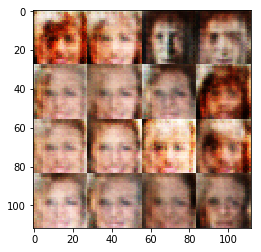

Epoch 0/1... Discriminator Loss: 1.7246... Generator Loss: 0.3407
Epoch 0/1... Discriminator Loss: 0.7190... Generator Loss: 1.5031
Epoch 0/1... Discriminator Loss: 0.9852... Generator Loss: 1.6414
Epoch 0/1... Discriminator Loss: 0.9154... Generator Loss: 1.0538
Epoch 0/1... Discriminator Loss: 0.9514... Generator Loss: 0.9557


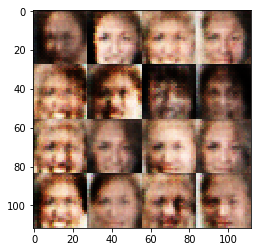

Epoch 0/1... Discriminator Loss: 0.7041... Generator Loss: 1.3981
Epoch 0/1... Discriminator Loss: 0.8933... Generator Loss: 0.8650
Epoch 0/1... Discriminator Loss: 1.0489... Generator Loss: 1.8639
Epoch 0/1... Discriminator Loss: 0.7536... Generator Loss: 1.2305
Epoch 0/1... Discriminator Loss: 1.0261... Generator Loss: 2.3858


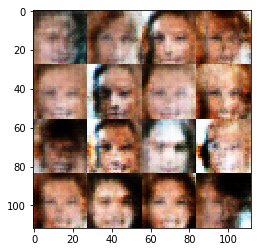

Epoch 0/1... Discriminator Loss: 1.0361... Generator Loss: 0.8966
Epoch 0/1... Discriminator Loss: 1.1574... Generator Loss: 0.5820
Epoch 0/1... Discriminator Loss: 1.1869... Generator Loss: 1.0538
Epoch 0/1... Discriminator Loss: 0.8347... Generator Loss: 1.7143
Epoch 0/1... Discriminator Loss: 0.9689... Generator Loss: 1.3656


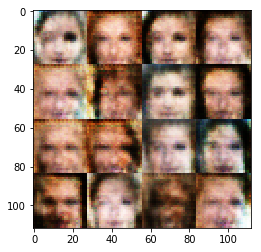

Epoch 0/1... Discriminator Loss: 0.8124... Generator Loss: 1.1253
Epoch 0/1... Discriminator Loss: 0.9841... Generator Loss: 0.9885
Epoch 0/1... Discriminator Loss: 0.7878... Generator Loss: 1.0688
Epoch 0/1... Discriminator Loss: 1.1783... Generator Loss: 0.6539
Epoch 0/1... Discriminator Loss: 1.1736... Generator Loss: 0.8135


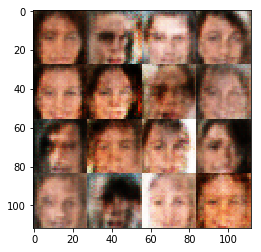

Epoch 0/1... Discriminator Loss: 0.6119... Generator Loss: 1.7221
Epoch 0/1... Discriminator Loss: 1.0845... Generator Loss: 0.7065
Epoch 0/1... Discriminator Loss: 0.9617... Generator Loss: 1.2406
Epoch 0/1... Discriminator Loss: 0.9032... Generator Loss: 1.5311
Epoch 0/1... Discriminator Loss: 0.9991... Generator Loss: 0.8057


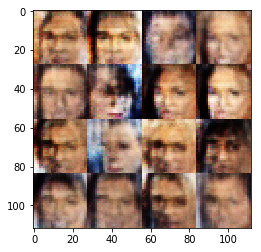

Epoch 0/1... Discriminator Loss: 1.0544... Generator Loss: 1.6917
Epoch 0/1... Discriminator Loss: 0.8874... Generator Loss: 1.1187
Epoch 0/1... Discriminator Loss: 0.9024... Generator Loss: 1.3797
Epoch 0/1... Discriminator Loss: 1.2018... Generator Loss: 1.8046
Epoch 0/1... Discriminator Loss: 0.8676... Generator Loss: 1.5848


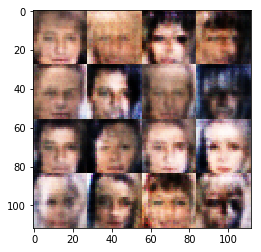

Epoch 0/1... Discriminator Loss: 1.0200... Generator Loss: 0.8683
Epoch 0/1... Discriminator Loss: 1.2632... Generator Loss: 0.8363
Epoch 0/1... Discriminator Loss: 0.8942... Generator Loss: 0.9055
Epoch 0/1... Discriminator Loss: 0.9545... Generator Loss: 0.8812
Epoch 0/1... Discriminator Loss: 1.0817... Generator Loss: 0.7342


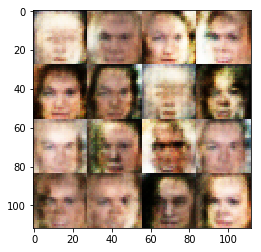

Epoch 0/1... Discriminator Loss: 1.0601... Generator Loss: 0.7125
Epoch 0/1... Discriminator Loss: 0.9638... Generator Loss: 1.2588
Epoch 0/1... Discriminator Loss: 1.3802... Generator Loss: 0.4417
Epoch 0/1... Discriminator Loss: 0.7872... Generator Loss: 1.4050
Epoch 0/1... Discriminator Loss: 0.8713... Generator Loss: 1.1966


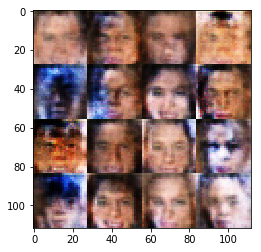

Epoch 0/1... Discriminator Loss: 1.4266... Generator Loss: 0.3936
Epoch 0/1... Discriminator Loss: 1.0380... Generator Loss: 0.9849
Epoch 0/1... Discriminator Loss: 0.8466... Generator Loss: 1.2534
Epoch 0/1... Discriminator Loss: 0.9786... Generator Loss: 0.8953
Epoch 0/1... Discriminator Loss: 0.7977... Generator Loss: 1.3430


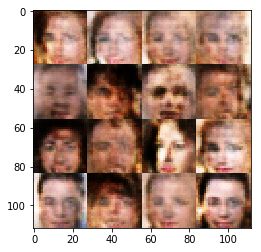

Epoch 0/1... Discriminator Loss: 1.2394... Generator Loss: 0.5482
Epoch 0/1... Discriminator Loss: 1.0871... Generator Loss: 0.9110
Epoch 0/1... Discriminator Loss: 1.0683... Generator Loss: 1.6584
Epoch 0/1... Discriminator Loss: 0.9218... Generator Loss: 1.8546
Epoch 0/1... Discriminator Loss: 1.4405... Generator Loss: 0.4413


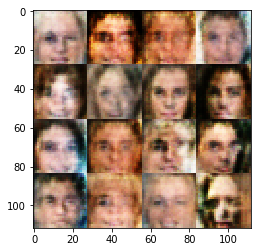

Epoch 0/1... Discriminator Loss: 1.0229... Generator Loss: 1.2440
Epoch 0/1... Discriminator Loss: 1.0535... Generator Loss: 0.9958
Epoch 0/1... Discriminator Loss: 0.9219... Generator Loss: 1.4968
Epoch 0/1... Discriminator Loss: 1.2502... Generator Loss: 0.5496
Epoch 0/1... Discriminator Loss: 0.9177... Generator Loss: 1.5827


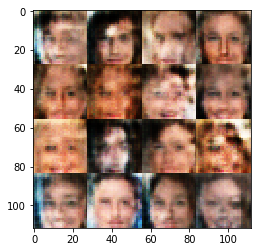

Epoch 0/1... Discriminator Loss: 0.9988... Generator Loss: 1.9179
Epoch 0/1... Discriminator Loss: 1.0646... Generator Loss: 1.8802
Epoch 0/1... Discriminator Loss: 1.1169... Generator Loss: 1.0421
Epoch 0/1... Discriminator Loss: 0.8214... Generator Loss: 1.0580
Epoch 0/1... Discriminator Loss: 0.8968... Generator Loss: 1.2949


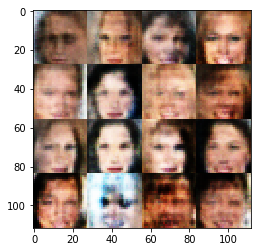

Epoch 0/1... Discriminator Loss: 0.9167... Generator Loss: 1.3115
Epoch 0/1... Discriminator Loss: 0.9070... Generator Loss: 1.5452
Epoch 0/1... Discriminator Loss: 0.9268... Generator Loss: 0.9459
Epoch 0/1... Discriminator Loss: 0.7334... Generator Loss: 1.0918
Epoch 0/1... Discriminator Loss: 0.8648... Generator Loss: 1.3180


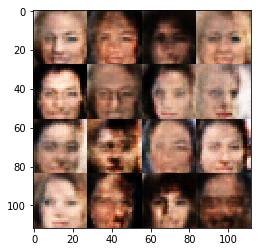

Epoch 0/1... Discriminator Loss: 0.9087... Generator Loss: 1.2271
Epoch 0/1... Discriminator Loss: 0.8439... Generator Loss: 1.0740
Epoch 0/1... Discriminator Loss: 0.8228... Generator Loss: 1.3891
Epoch 0/1... Discriminator Loss: 0.8584... Generator Loss: 1.4643
Epoch 0/1... Discriminator Loss: 0.9666... Generator Loss: 0.8324


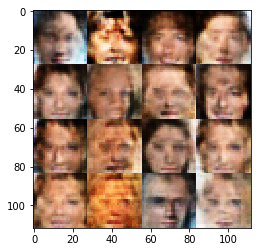

Epoch 0/1... Discriminator Loss: 1.3077... Generator Loss: 0.5482
Epoch 0/1... Discriminator Loss: 1.1276... Generator Loss: 0.6679
Epoch 0/1... Discriminator Loss: 0.8595... Generator Loss: 1.0244
Epoch 0/1... Discriminator Loss: 0.9293... Generator Loss: 1.4445
Epoch 0/1... Discriminator Loss: 0.9492... Generator Loss: 1.1703


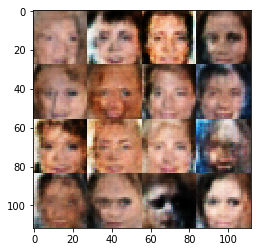

Epoch 0/1... Discriminator Loss: 1.0612... Generator Loss: 0.6851
Epoch 0/1... Discriminator Loss: 0.9470... Generator Loss: 1.5096
Epoch 0/1... Discriminator Loss: 0.9478... Generator Loss: 1.5059
Epoch 0/1... Discriminator Loss: 0.9809... Generator Loss: 1.4573
Epoch 0/1... Discriminator Loss: 0.8228... Generator Loss: 1.0141


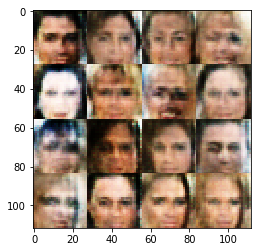

Epoch 0/1... Discriminator Loss: 1.0726... Generator Loss: 1.7431
Epoch 0/1... Discriminator Loss: 1.0359... Generator Loss: 0.8059
Epoch 0/1... Discriminator Loss: 1.0275... Generator Loss: 0.9808
Epoch 0/1... Discriminator Loss: 1.2132... Generator Loss: 1.2436
Epoch 0/1... Discriminator Loss: 1.3145... Generator Loss: 0.5336


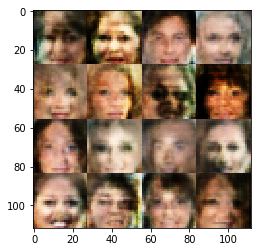

Epoch 0/1... Discriminator Loss: 1.4615... Generator Loss: 0.4201
Epoch 0/1... Discriminator Loss: 0.8030... Generator Loss: 1.3903
Epoch 0/1... Discriminator Loss: 1.0982... Generator Loss: 0.7073
Epoch 0/1... Discriminator Loss: 0.8838... Generator Loss: 1.1827
Epoch 0/1... Discriminator Loss: 1.0726... Generator Loss: 0.6807


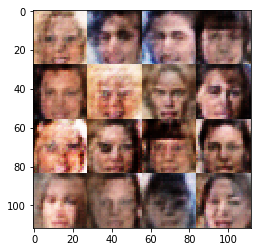

Epoch 0/1... Discriminator Loss: 0.9571... Generator Loss: 0.8725
Epoch 0/1... Discriminator Loss: 1.0088... Generator Loss: 0.9799
Epoch 0/1... Discriminator Loss: 1.0628... Generator Loss: 1.8003
Epoch 0/1... Discriminator Loss: 1.0570... Generator Loss: 0.7860
Epoch 0/1... Discriminator Loss: 1.1958... Generator Loss: 1.0913


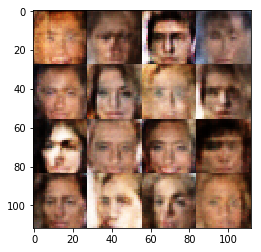

Epoch 0/1... Discriminator Loss: 1.2007... Generator Loss: 1.1785
Epoch 0/1... Discriminator Loss: 1.1588... Generator Loss: 0.7312
Epoch 0/1... Discriminator Loss: 1.2716... Generator Loss: 1.8042
Epoch 0/1... Discriminator Loss: 0.9001... Generator Loss: 0.9568
Epoch 0/1... Discriminator Loss: 1.0648... Generator Loss: 0.5978


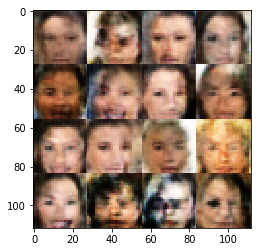

Epoch 0/1... Discriminator Loss: 1.1831... Generator Loss: 0.6758
Epoch 0/1... Discriminator Loss: 1.1347... Generator Loss: 1.0278
Epoch 0/1... Discriminator Loss: 1.2148... Generator Loss: 1.0529
Epoch 0/1... Discriminator Loss: 0.9657... Generator Loss: 1.3807
Epoch 0/1... Discriminator Loss: 1.3535... Generator Loss: 0.4648


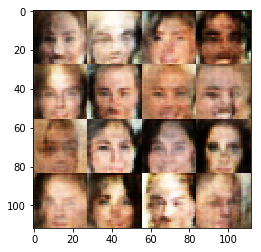

Epoch 0/1... Discriminator Loss: 1.3116... Generator Loss: 0.4868
Epoch 0/1... Discriminator Loss: 1.2207... Generator Loss: 0.6048
Epoch 0/1... Discriminator Loss: 1.1886... Generator Loss: 1.5511
Epoch 0/1... Discriminator Loss: 1.0087... Generator Loss: 1.3831
Epoch 0/1... Discriminator Loss: 1.0957... Generator Loss: 0.8323


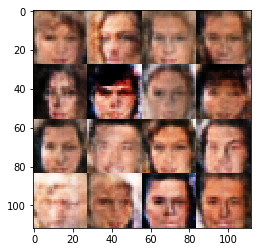

Epoch 0/1... Discriminator Loss: 0.8210... Generator Loss: 1.1690
Epoch 0/1... Discriminator Loss: 1.1312... Generator Loss: 0.8121
Epoch 0/1... Discriminator Loss: 1.0869... Generator Loss: 0.7852
Epoch 0/1... Discriminator Loss: 1.0890... Generator Loss: 1.8055
Epoch 0/1... Discriminator Loss: 0.9932... Generator Loss: 0.9091


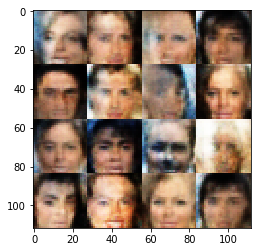

Epoch 0/1... Discriminator Loss: 1.0339... Generator Loss: 1.0753
Epoch 0/1... Discriminator Loss: 0.7161... Generator Loss: 1.3734
Epoch 0/1... Discriminator Loss: 0.9643... Generator Loss: 0.8843
Epoch 0/1... Discriminator Loss: 1.1543... Generator Loss: 0.7500
Epoch 0/1... Discriminator Loss: 0.9989... Generator Loss: 0.9388


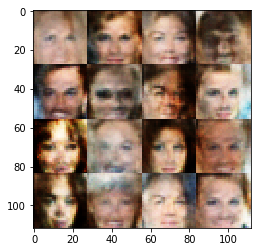

Epoch 0/1... Discriminator Loss: 0.9737... Generator Loss: 0.8704
Epoch 0/1... Discriminator Loss: 0.7774... Generator Loss: 1.2429
Epoch 0/1... Discriminator Loss: 0.9960... Generator Loss: 0.8373
Epoch 0/1... Discriminator Loss: 0.8747... Generator Loss: 1.1697
Epoch 0/1... Discriminator Loss: 1.4014... Generator Loss: 0.4005


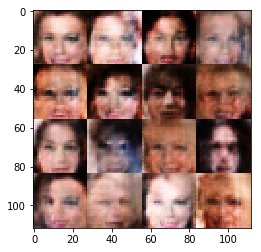

Epoch 0/1... Discriminator Loss: 0.9469... Generator Loss: 1.0860
Epoch 0/1... Discriminator Loss: 1.1476... Generator Loss: 0.6653
Epoch 0/1... Discriminator Loss: 0.8059... Generator Loss: 1.3371
Epoch 0/1... Discriminator Loss: 0.9960... Generator Loss: 1.0451
Epoch 0/1... Discriminator Loss: 1.6040... Generator Loss: 2.4551


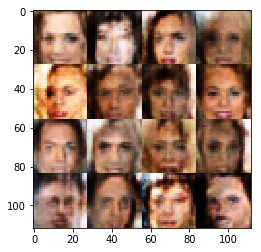

Epoch 0/1... Discriminator Loss: 1.1574... Generator Loss: 0.8711
Epoch 0/1... Discriminator Loss: 0.8172... Generator Loss: 1.1679
Epoch 0/1... Discriminator Loss: 0.8709... Generator Loss: 1.4337
Epoch 0/1... Discriminator Loss: 0.9006... Generator Loss: 1.0631
Epoch 0/1... Discriminator Loss: 0.9492... Generator Loss: 1.7496


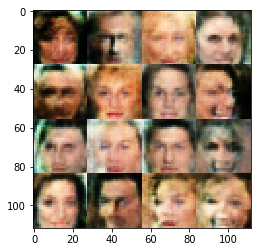

Epoch 0/1... Discriminator Loss: 0.8255... Generator Loss: 1.0830
Epoch 0/1... Discriminator Loss: 0.7952... Generator Loss: 1.3048
Epoch 0/1... Discriminator Loss: 0.9118... Generator Loss: 1.0866
Epoch 0/1... Discriminator Loss: 0.8301... Generator Loss: 1.4702
Epoch 0/1... Discriminator Loss: 0.7691... Generator Loss: 1.4263


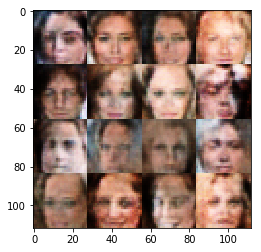

Epoch 0/1... Discriminator Loss: 1.0813... Generator Loss: 1.0316
Epoch 0/1... Discriminator Loss: 1.3005... Generator Loss: 0.4534
Epoch 0/1... Discriminator Loss: 0.9630... Generator Loss: 0.8268
Epoch 0/1... Discriminator Loss: 1.1852... Generator Loss: 0.5974
Epoch 0/1... Discriminator Loss: 1.2266... Generator Loss: 0.5750


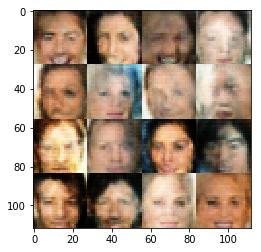

Epoch 0/1... Discriminator Loss: 0.9113... Generator Loss: 1.2864
Epoch 0/1... Discriminator Loss: 0.9877... Generator Loss: 1.0237
Epoch 0/1... Discriminator Loss: 0.9461... Generator Loss: 1.0671
Epoch 0/1... Discriminator Loss: 1.3689... Generator Loss: 0.4766
Epoch 0/1... Discriminator Loss: 1.4372... Generator Loss: 0.4686


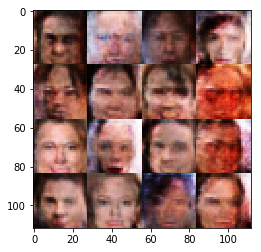

Epoch 0/1... Discriminator Loss: 0.7608... Generator Loss: 1.3928
Epoch 0/1... Discriminator Loss: 0.8381... Generator Loss: 0.8828
Epoch 0/1... Discriminator Loss: 1.3588... Generator Loss: 0.4760
Epoch 0/1... Discriminator Loss: 1.1854... Generator Loss: 0.5652
Epoch 0/1... Discriminator Loss: 1.5202... Generator Loss: 0.3584


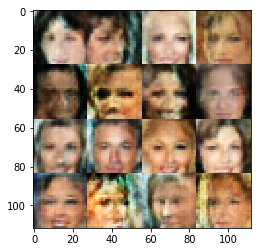

Epoch 0/1... Discriminator Loss: 0.9659... Generator Loss: 0.9307
Epoch 0/1... Discriminator Loss: 1.0385... Generator Loss: 0.7233
Epoch 0/1... Discriminator Loss: 0.8080... Generator Loss: 1.1431
Epoch 0/1... Discriminator Loss: 1.0286... Generator Loss: 0.8010
Epoch 0/1... Discriminator Loss: 0.9443... Generator Loss: 1.6773


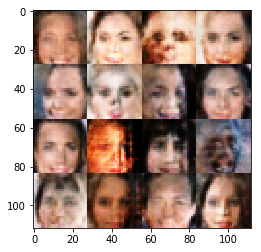

Epoch 0/1... Discriminator Loss: 0.9626... Generator Loss: 1.3939
Epoch 0/1... Discriminator Loss: 1.0114... Generator Loss: 1.4170
Epoch 0/1... Discriminator Loss: 0.7668... Generator Loss: 1.5315
Epoch 0/1... Discriminator Loss: 1.0818... Generator Loss: 1.6709
Epoch 0/1... Discriminator Loss: 0.8006... Generator Loss: 1.0052


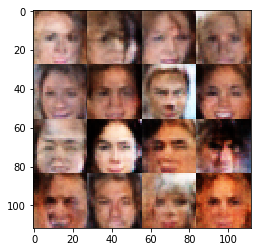

Epoch 0/1... Discriminator Loss: 0.9841... Generator Loss: 0.9128
Epoch 0/1... Discriminator Loss: 1.2096... Generator Loss: 2.0731
Epoch 0/1... Discriminator Loss: 0.9470... Generator Loss: 0.9893
Epoch 0/1... Discriminator Loss: 0.9071... Generator Loss: 0.9222
Epoch 0/1... Discriminator Loss: 0.8249... Generator Loss: 2.0389


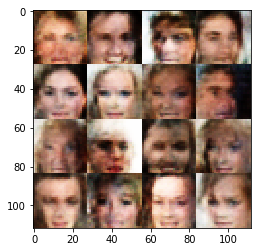

Epoch 0/1... Discriminator Loss: 0.8644... Generator Loss: 1.0584
Epoch 0/1... Discriminator Loss: 0.9552... Generator Loss: 1.2485
Epoch 0/1... Discriminator Loss: 1.0596... Generator Loss: 1.1370
Epoch 0/1... Discriminator Loss: 1.2388... Generator Loss: 1.7862
Epoch 0/1... Discriminator Loss: 1.0593... Generator Loss: 0.7082


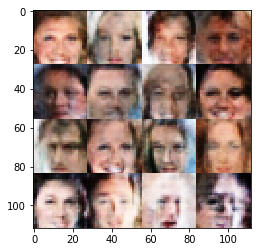

Epoch 0/1... Discriminator Loss: 1.0614... Generator Loss: 0.7431
Epoch 0/1... Discriminator Loss: 0.7083... Generator Loss: 1.8247
Epoch 0/1... Discriminator Loss: 1.1029... Generator Loss: 0.7334
Epoch 0/1... Discriminator Loss: 0.9890... Generator Loss: 1.0843
Epoch 0/1... Discriminator Loss: 1.2608... Generator Loss: 1.5345


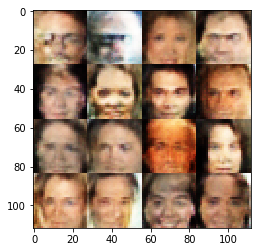

Epoch 0/1... Discriminator Loss: 0.9449... Generator Loss: 1.2335
Epoch 0/1... Discriminator Loss: 1.0292... Generator Loss: 0.6908
Epoch 0/1... Discriminator Loss: 0.9660... Generator Loss: 1.2418
Epoch 0/1... Discriminator Loss: 0.6464... Generator Loss: 1.6553
Epoch 0/1... Discriminator Loss: 1.1076... Generator Loss: 1.0662


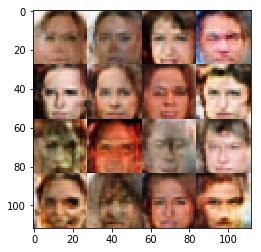

Epoch 0/1... Discriminator Loss: 0.8868... Generator Loss: 1.0938
Epoch 0/1... Discriminator Loss: 0.9061... Generator Loss: 1.3332
Epoch 0/1... Discriminator Loss: 1.0842... Generator Loss: 1.3332
Epoch 0/1... Discriminator Loss: 1.6581... Generator Loss: 0.3070
Epoch 0/1... Discriminator Loss: 0.9955... Generator Loss: 1.1725


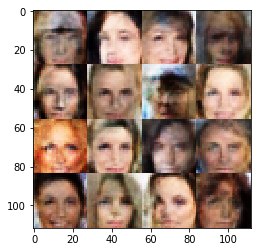

Epoch 0/1... Discriminator Loss: 0.9307... Generator Loss: 1.7220
Epoch 0/1... Discriminator Loss: 0.8856... Generator Loss: 1.3696
Epoch 0/1... Discriminator Loss: 0.8885... Generator Loss: 0.9771
Epoch 0/1... Discriminator Loss: 1.1424... Generator Loss: 0.6938
Epoch 0/1... Discriminator Loss: 1.1151... Generator Loss: 0.6085


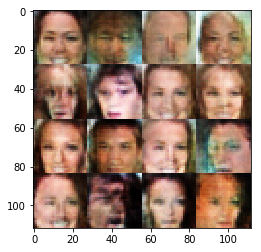

Epoch 0/1... Discriminator Loss: 1.2542... Generator Loss: 1.2329
Epoch 0/1... Discriminator Loss: 1.0053... Generator Loss: 0.9531
Epoch 0/1... Discriminator Loss: 1.1311... Generator Loss: 1.8672
Epoch 0/1... Discriminator Loss: 1.2338... Generator Loss: 0.5941
Epoch 0/1... Discriminator Loss: 1.2994... Generator Loss: 0.5540


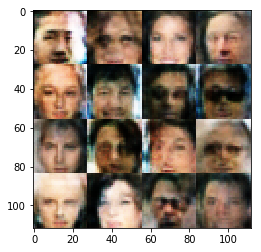

Epoch 0/1... Discriminator Loss: 1.0659... Generator Loss: 0.6569
Epoch 0/1... Discriminator Loss: 0.9502... Generator Loss: 0.9118
Epoch 0/1... Discriminator Loss: 1.0978... Generator Loss: 1.1263
Epoch 0/1... Discriminator Loss: 1.1933... Generator Loss: 0.6380
Epoch 0/1... Discriminator Loss: 0.9971... Generator Loss: 0.8017


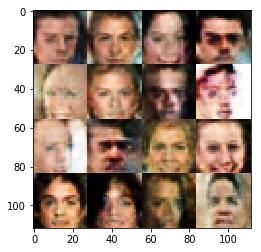

Epoch 0/1... Discriminator Loss: 1.0339... Generator Loss: 0.6719
Epoch 0/1... Discriminator Loss: 1.0155... Generator Loss: 1.9844
Epoch 0/1... Discriminator Loss: 0.9237... Generator Loss: 1.1397
Epoch 0/1... Discriminator Loss: 1.1796... Generator Loss: 0.6371
Epoch 0/1... Discriminator Loss: 0.9489... Generator Loss: 1.3966


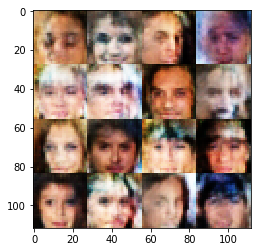

Epoch 0/1... Discriminator Loss: 1.0631... Generator Loss: 0.6491
Epoch 0/1... Discriminator Loss: 0.8994... Generator Loss: 1.1534
Epoch 0/1... Discriminator Loss: 1.0675... Generator Loss: 0.6466
Epoch 0/1... Discriminator Loss: 1.2542... Generator Loss: 0.4662
Epoch 0/1... Discriminator Loss: 1.3066... Generator Loss: 1.7855


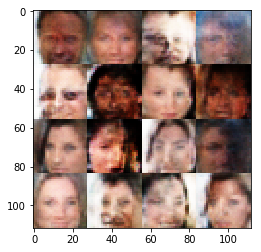

Epoch 0/1... Discriminator Loss: 0.9254... Generator Loss: 1.0968
Epoch 0/1... Discriminator Loss: 0.9190... Generator Loss: 1.0831
Epoch 0/1... Discriminator Loss: 1.4598... Generator Loss: 1.6319
Epoch 0/1... Discriminator Loss: 0.7803... Generator Loss: 1.4055
Epoch 0/1... Discriminator Loss: 1.2578... Generator Loss: 0.5636


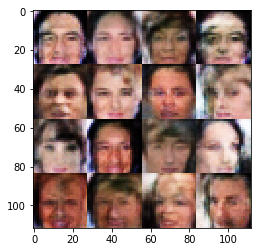

Epoch 0/1... Discriminator Loss: 0.7222... Generator Loss: 1.2950
Epoch 0/1... Discriminator Loss: 1.4321... Generator Loss: 0.5750
Epoch 0/1... Discriminator Loss: 0.9480... Generator Loss: 0.7580
Epoch 0/1... Discriminator Loss: 1.1242... Generator Loss: 0.6416
Epoch 0/1... Discriminator Loss: 1.0508... Generator Loss: 0.9040


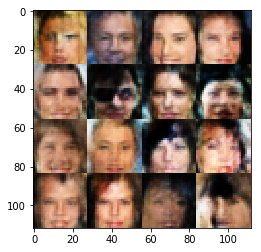

Epoch 0/1... Discriminator Loss: 1.2106... Generator Loss: 0.6165
Epoch 0/1... Discriminator Loss: 0.8006... Generator Loss: 1.3873


In [17]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.